In [1]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "dataset"
print(os.listdir(dataset_path))

['Drowsy', 'Non Drowsy']


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip to generalize left/right faces
    transforms.RandomRotation(10),  # Slight rotation to account for natural head tilt
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),  # More variability in lighting
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),  # Small shifts & rotations
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),  # Simulate motion blur
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root=dataset_path, transform=transform)

In [4]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.7, 0.2, 0.1])

# Print dataset sizes
print(f"Training Samples: {len(train_dataset)}")
print(f"Validation Samples: {len(val_dataset)}")
print(f"Test Samples: {len(test_dataset)}")
print(f"Classes: {dataset.classes}")

subset_train = Subset(train_dataset,range(1000))
subset_val = Subset(val_dataset, range(1000))

# Create DataLoaders
train_loader = DataLoader(subset_train, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(subset_val, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Training Samples: 29256
Validation Samples: 8358
Test Samples: 4179
Classes: ['Drowsy', 'Non Drowsy']


In [5]:
def plot_images_grid(dataloader, mean, std):
    for images, labels in dataloader:
        break
    _, axes = plt.subplots(3, 3, figsize=(6, 6))
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    for ax, image, label in zip(axes.flatten(), images, labels):            
        image = image * std + mean
        image = torch.clamp(image, 0, 1)
        image = image.permute(1, 2, 0)  # Change the order of dimensions to (H, W, C)
        ax.imshow(image)
        ax.set_title(f"Label: {label.item()}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Train set


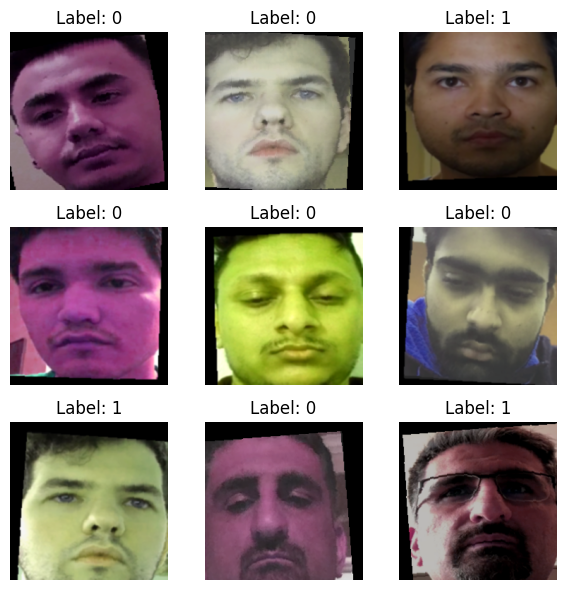

Valid set


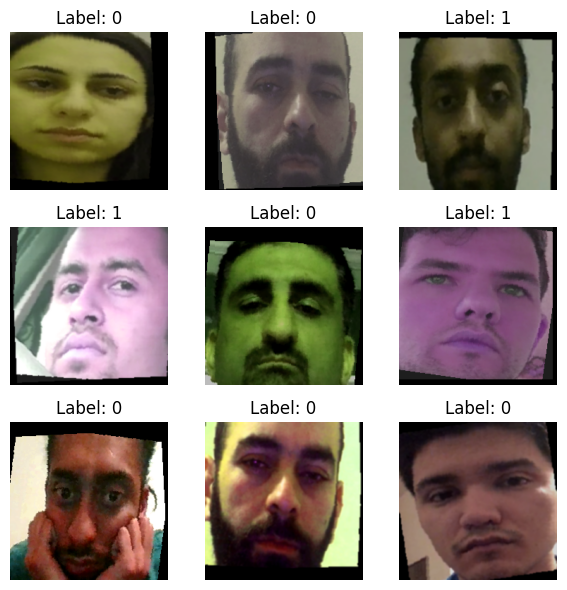

Test set


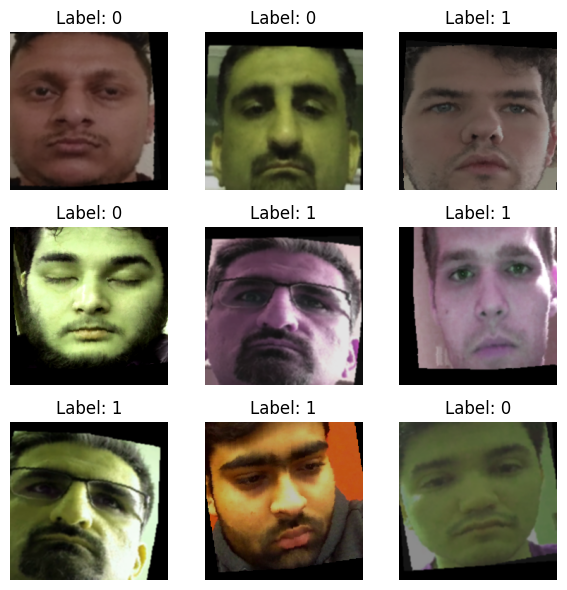

In [6]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
print("Train set"); plot_images_grid(train_loader, mean, std)
print("Valid set"); plot_images_grid(val_loader, mean, std)
print("Test set"); plot_images_grid(test_loader, mean, std)

In [7]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        base_model = models.mobilenet_v3_large(pretrained=True)
        self.features = base_model.features  # CNN feature extractor

        # Get the number of features coming out of the CNN
        n_features = base_model.classifier[0].in_features

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)

        # Final classification layers (for binary, use 2 classes with CrossEntropyLoss)
        self.classifier = nn.Sequential(
            nn.Linear(n_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2)  # Output 2 logits (not 1) for CrossEntropyLoss
        )

    def forward(self, x):
        x = self.features(x)          # Shape: [B, 960, 7, 7]
        x = self.avgpool(x)           # Shape: [B, 960, 1, 1]
        x = x.view(x.size(0), -1)     # Flatten to [B, 960]
        x = self.dropout(x)
        x = self.classifier(x)        # Final output shape: [B, 2]
        return x


In [8]:
model = CNN().to(device)

c:\Users\USER\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# Paths for saving
checkpoint_path = "checkpoint.pth"
best_model_path = "best_model.pth"
log_path = "training_log.txt"

In [10]:
checkpoint_path = "model3_checkpoint.pth"
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    # MobileNetV3plusCNN.load_state_dict(checkpoint['model_state_dict'])
    CNN.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_loss = checkpoint['loss']
    print(f"Checkpoint Loaded! Resuming from Epoch {start_epoch+1} with best loss {best_loss:.4f}")
else:
    start_epoch = 0
    best_loss = float("inf")

In [11]:
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    # MobileNetV3plusCNN.load_state_dict(checkpoint['model_state_dict'])
    CNN.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_loss = checkpoint['loss']
    print(f"🔄 Resuming training from Epoch {start_epoch}...")
else:
    start_epoch = 0
    best_loss = float('inf')

In [12]:
epochs = 50
train_losses = []
val_losses = []
val_accuracies = []

patience = 3
counter = 0

In [13]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total

In [14]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validating", leave=False):
            images = images.to(device)
            labels = labels.to(device).long()
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / total
    val_accuracy = correct / total

    return avg_val_loss, val_accuracy

In [15]:
def train_model(model, train_loader, val_loader, device, epochs=10, lr=1e-4, save_path='training_plot_CNNMobileNetV3.png'):

    best_val_acc = 0.0
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)
            labels = labels.to(device).long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = train_loss / total
        train_acc = correct / total

        # Validation
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc * 100)

        print(f"Train Loss: {avg_train_loss:.4f}, Accuracy: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")

    print("Training complete.")

    # Plotting
    plt.figure(figsize=(12, 6))

    # Loss vs Epochs
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs. Epochs")
    plt.legend()

    # Accuracy vs Epochs
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy vs. Epochs")
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    print(f"Training plot saved to: {save_path}")

    return model


Epoch 1/50


Training: 100%|██████████| 8/8 [00:40<00:00,  5.05s/it]


Train Loss: 0.6820, Accuracy: 0.5690
Val   Loss: 0.6813, Accuracy: 0.5820
Best model saved!

Epoch 2/50


Training: 100%|██████████| 8/8 [00:38<00:00,  4.87s/it]


Train Loss: 0.6340, Accuracy: 0.6860
Val   Loss: 0.6653, Accuracy: 0.5780

Epoch 3/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.91s/it]


Train Loss: 0.5680, Accuracy: 0.7630
Val   Loss: 0.6348, Accuracy: 0.6150
Best model saved!

Epoch 4/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.89s/it]


Train Loss: 0.4659, Accuracy: 0.8360
Val   Loss: 0.5793, Accuracy: 0.6660
Best model saved!

Epoch 5/50


Training: 100%|██████████| 8/8 [00:38<00:00,  4.85s/it]


Train Loss: 0.3521, Accuracy: 0.8780
Val   Loss: 0.5143, Accuracy: 0.7070
Best model saved!

Epoch 6/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.90s/it]


Train Loss: 0.2385, Accuracy: 0.9320
Val   Loss: 0.4019, Accuracy: 0.8050
Best model saved!

Epoch 7/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.91s/it]


Train Loss: 0.1442, Accuracy: 0.9580
Val   Loss: 0.3396, Accuracy: 0.8510
Best model saved!

Epoch 8/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.89s/it]


Train Loss: 0.1060, Accuracy: 0.9650
Val   Loss: 0.2897, Accuracy: 0.8820
Best model saved!

Epoch 9/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.96s/it]


Train Loss: 0.0600, Accuracy: 0.9830
Val   Loss: 0.2623, Accuracy: 0.8970
Best model saved!

Epoch 10/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.98s/it]


Train Loss: 0.0431, Accuracy: 0.9880
Val   Loss: 0.2471, Accuracy: 0.8980
Best model saved!

Epoch 11/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.95s/it]


Train Loss: 0.0292, Accuracy: 0.9930
Val   Loss: 0.1701, Accuracy: 0.9350
Best model saved!

Epoch 12/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.93s/it]


Train Loss: 0.0311, Accuracy: 0.9880
Val   Loss: 0.1127, Accuracy: 0.9600
Best model saved!

Epoch 13/50


Training: 100%|██████████| 8/8 [00:38<00:00,  4.86s/it]


Train Loss: 0.0174, Accuracy: 0.9970
Val   Loss: 0.1059, Accuracy: 0.9540

Epoch 14/50


Training: 100%|██████████| 8/8 [00:38<00:00,  4.87s/it]


Train Loss: 0.0260, Accuracy: 0.9890
Val   Loss: 0.0598, Accuracy: 0.9840
Best model saved!

Epoch 15/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.90s/it]


Train Loss: 0.0139, Accuracy: 0.9960
Val   Loss: 0.0635, Accuracy: 0.9770

Epoch 16/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.91s/it]


Train Loss: 0.0139, Accuracy: 0.9950
Val   Loss: 0.0339, Accuracy: 0.9860
Best model saved!

Epoch 17/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.91s/it]


Train Loss: 0.0126, Accuracy: 0.9960
Val   Loss: 0.0313, Accuracy: 0.9930
Best model saved!

Epoch 18/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.94s/it]


Train Loss: 0.0069, Accuracy: 0.9980
Val   Loss: 0.0346, Accuracy: 0.9870

Epoch 19/50


Training: 100%|██████████| 8/8 [00:38<00:00,  4.86s/it]


Train Loss: 0.0128, Accuracy: 0.9960
Val   Loss: 0.0359, Accuracy: 0.9850

Epoch 20/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.97s/it]


Train Loss: 0.0081, Accuracy: 0.9960
Val   Loss: 0.0222, Accuracy: 0.9940
Best model saved!

Epoch 21/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.92s/it]


Train Loss: 0.0079, Accuracy: 0.9980
Val   Loss: 0.0203, Accuracy: 0.9950
Best model saved!

Epoch 22/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.90s/it]


Train Loss: 0.0043, Accuracy: 1.0000
Val   Loss: 0.0182, Accuracy: 0.9930

Epoch 23/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.89s/it]


Train Loss: 0.0089, Accuracy: 0.9970
Val   Loss: 0.0213, Accuracy: 0.9890

Epoch 24/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.92s/it]


Train Loss: 0.0052, Accuracy: 0.9980
Val   Loss: 0.0123, Accuracy: 0.9960
Best model saved!

Epoch 25/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.91s/it]


Train Loss: 0.0056, Accuracy: 0.9980
Val   Loss: 0.0126, Accuracy: 0.9960

Epoch 26/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.92s/it]


Train Loss: 0.0112, Accuracy: 0.9950
Val   Loss: 0.0244, Accuracy: 0.9920

Epoch 27/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.90s/it]


Train Loss: 0.0053, Accuracy: 0.9980
Val   Loss: 0.0233, Accuracy: 0.9920

Epoch 28/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.90s/it]


Train Loss: 0.0097, Accuracy: 0.9970
Val   Loss: 0.0103, Accuracy: 0.9950

Epoch 29/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.94s/it]


Train Loss: 0.0077, Accuracy: 0.9980
Val   Loss: 0.0084, Accuracy: 0.9980
Best model saved!

Epoch 30/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.93s/it]


Train Loss: 0.0023, Accuracy: 1.0000
Val   Loss: 0.0138, Accuracy: 0.9950

Epoch 31/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.88s/it]


Train Loss: 0.0069, Accuracy: 0.9970
Val   Loss: 0.0123, Accuracy: 0.9970

Epoch 32/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.89s/it]


Train Loss: 0.0052, Accuracy: 0.9990
Val   Loss: 0.0071, Accuracy: 0.9970

Epoch 33/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.91s/it]


Train Loss: 0.0045, Accuracy: 0.9990
Val   Loss: 0.0109, Accuracy: 0.9950

Epoch 34/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.90s/it]


Train Loss: 0.0041, Accuracy: 0.9990
Val   Loss: 0.0167, Accuracy: 0.9940

Epoch 35/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.93s/it]


Train Loss: 0.0033, Accuracy: 0.9980
Val   Loss: 0.0091, Accuracy: 0.9970

Epoch 36/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.89s/it]


Train Loss: 0.0021, Accuracy: 1.0000
Val   Loss: 0.0071, Accuracy: 0.9960

Epoch 37/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.91s/it]


Train Loss: 0.0020, Accuracy: 1.0000
Val   Loss: 0.0136, Accuracy: 0.9960

Epoch 38/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.96s/it]


Train Loss: 0.0008, Accuracy: 1.0000
Val   Loss: 0.0093, Accuracy: 0.9970

Epoch 39/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.94s/it]


Train Loss: 0.0007, Accuracy: 1.0000
Val   Loss: 0.0043, Accuracy: 0.9990
Best model saved!

Epoch 40/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.97s/it]


Train Loss: 0.0011, Accuracy: 1.0000
Val   Loss: 0.0076, Accuracy: 0.9970

Epoch 41/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.94s/it]


Train Loss: 0.0018, Accuracy: 1.0000
Val   Loss: 0.0080, Accuracy: 0.9970

Epoch 42/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.97s/it]


Train Loss: 0.0020, Accuracy: 1.0000
Val   Loss: 0.0017, Accuracy: 1.0000
Best model saved!

Epoch 43/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.97s/it]


Train Loss: 0.0022, Accuracy: 1.0000
Val   Loss: 0.0026, Accuracy: 0.9980

Epoch 44/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.92s/it]


Train Loss: 0.0019, Accuracy: 1.0000
Val   Loss: 0.0018, Accuracy: 1.0000

Epoch 45/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.91s/it]


Train Loss: 0.0020, Accuracy: 0.9990
Val   Loss: 0.0055, Accuracy: 0.9980

Epoch 46/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.94s/it]


Train Loss: 0.0007, Accuracy: 1.0000
Val   Loss: 0.0013, Accuracy: 1.0000

Epoch 47/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.94s/it]


Train Loss: 0.0013, Accuracy: 1.0000
Val   Loss: 0.0058, Accuracy: 0.9990

Epoch 48/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.97s/it]


Train Loss: 0.0005, Accuracy: 1.0000
Val   Loss: 0.0100, Accuracy: 0.9980

Epoch 49/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.94s/it]


Train Loss: 0.0011, Accuracy: 1.0000
Val   Loss: 0.0065, Accuracy: 0.9990

Epoch 50/50


Training: 100%|██████████| 8/8 [00:39<00:00,  4.99s/it]


Train Loss: 0.0049, Accuracy: 0.9990
Val   Loss: 0.0017, Accuracy: 0.9990
Training complete.


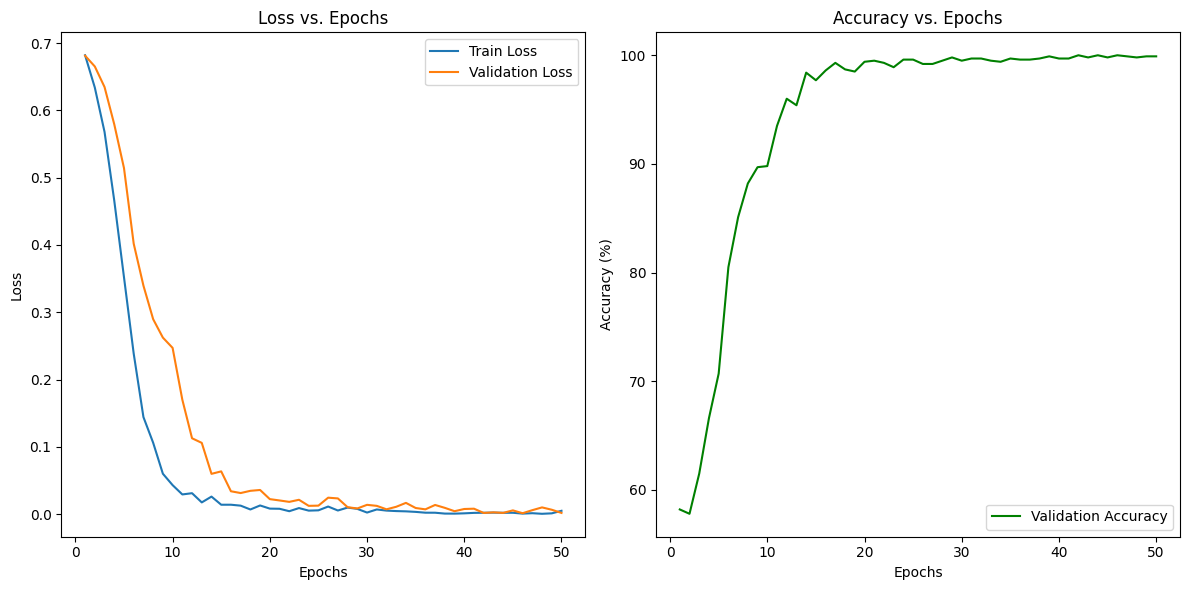

Training plot saved to: training_plot_CNNMobileNetV3.png


In [16]:
trained_model = train_model(model, train_loader, val_loader, device, epochs)

In [17]:
# Load trained weights
model.load_state_dict(torch.load("best_model.pth"))

# Move to device
model = model.to(device)
model.eval()

CNN(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False

In [18]:
# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = (correct / total) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 99.81%


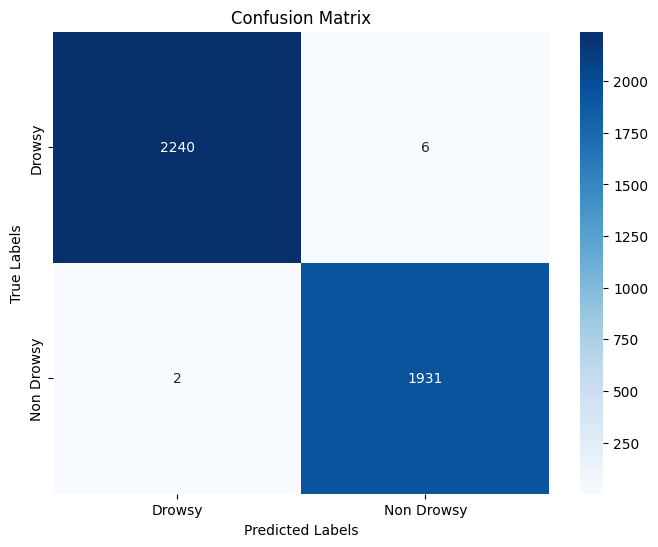

In [19]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()